In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("AmesHousing.csv")
features_to_keep = ['Lot Area','Lot Shape','House Style','Neighborhood', 'Year Built','Bsmt Cond','Central Air','Overall Cond','Full Bath','TotRms AbvGrd','Fireplaces','Garage Area','Yr Sold','SalePrice']
df = df[features_to_keep]
# Fill Bsmt Cond (categorical feature) with 'None'
df["Bsmt Cond"] = df["Bsmt Cond"].fillna("None")

# Fill Garage Area with 0 (assumes missing = no garage)
df["Garage Area"] = df["Garage Area"].fillna(0)

In [4]:
# Separate features and target
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


# List of categorical and numeric columns
categorical_cols = ["Lot Shape", "House Style", "Neighborhood", "Bsmt Cond", "Central Air"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]



In [ ]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
correlation_matrix = numerical_df.corr()

# Set figure size for better readability
plt.figure(figsize=(13, 7))

# Create a heatmap with improved styling
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title with emphasis
plt.title("Correlation Heatmap (Numerical Features Only)", fontsize=15, fontweight='bold')

# Improving axis labels for clarity
plt.xlabel("Features", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.savefig('correlation_heatmap.png')
# Displaying the final plot
plt.show()

In [ ]:
# Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ]
)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100,random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []

for name, reg in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),   # same preprocessor for all
        ("regressor", reg)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mpe = np.mean((y_test - y_pred) / y_test) * 100

    results.append({
        "Model": name,
        "RMSE": round(rmse,2),
        "MAE": round(mae,2),
        "R²": round(r2,2),
        "MAPE (%)": round(mape,2),
        "MPE (%)": round(mpe,2)
    })

# Convert to DataFrame for comparison
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)

               Model      RMSE       MAE    R²  MAPE (%)  MPE (%)
2            XGBoost  37071.42  21795.56  0.83     11.32    -2.56
1      Random Forest  37533.28  21647.81  0.82     11.37    -3.54
0  Linear Regression  41276.68  26285.24  0.79     13.71    -1.49


## Visualizing the Results

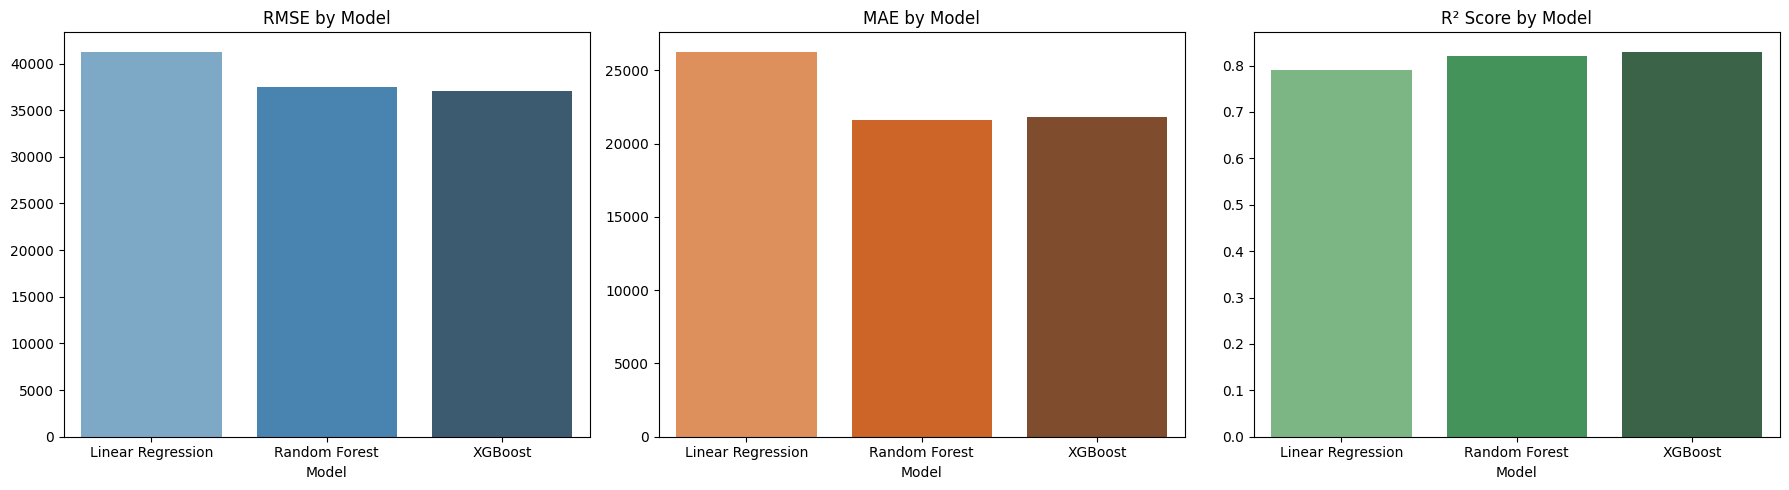

In [25]:
results_df = pd.DataFrame(results)

# Set figure size and create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot RMSE
sns.barplot(ax=axes[0], data=results_df, x="Model", y="RMSE", palette="Blues_d",hue="Model", legend=False)
axes[0].set_title("RMSE by Model")

# Plot MAE
sns.barplot(ax=axes[1], data=results_df, x="Model", y="MAE", palette="Oranges_d",hue="Model", legend=False)
axes[1].set_title("MAE by Model")

# Plot R²
sns.barplot(ax=axes[2], data=results_df, x="Model", y="R²", palette="Greens_d",hue="Model", legend=False)
axes[2].set_title("R² Score by Model")

# Clean up layout
for ax in axes:
    ax.set_xlabel("Model")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


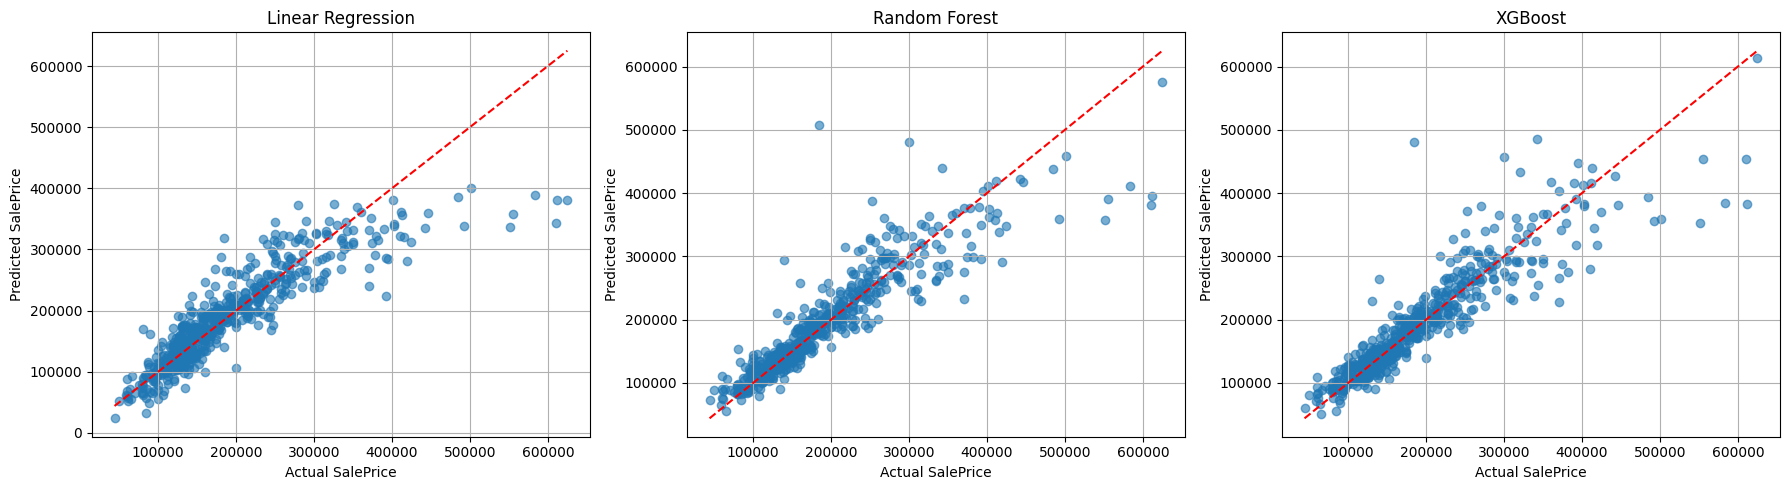

In [27]:
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))

# Make sure results_df and models are in the same order
for i, (name, reg) in enumerate(models.items()):
    # Rebuild and retrain pipeline
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("regressor", reg)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Scatter plot: actual vs predicted
    ax = axes[i] if len(models) > 1 else axes
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
    ax.set_title(f"{name}")
    ax.set_xlabel("Actual SalePrice")
    ax.set_ylabel("Predicted SalePrice")
    ax.grid(True)

plt.tight_layout()
plt.show()


## An Example of Searching for the Best Hyperparameters

In [28]:
# Here, you can add different values for the hyperparameters as desired. I am keeping this to a smaller grid to conserve time.
param_grid = {
    "regressor__n_estimators": [50,100,200],
    "regressor__max_depth": [None,5, 10, 20],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2],
}
rf_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

search = GridSearchCV(
    rf_model,               
    param_grid,              # search space
    cv=5,                    # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",  # you can also use "r2"
    n_jobs=-1,               # use all CPU cores
    verbose=2
)

search.fit(X_train, y_train)
print("Best parameters:", search.best_params_)
print("Best RMSE score (CV):", -search.best_score_)

# Use best model on test set
best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print("Test RMSE:", test_rmse)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best RMSE score (CV): 33093.26205907554
Test RMSE: 37657.02820955306
